# Human Diversity Data

This notebook includes getting the human diversity data in shape for the model fitting. 

## Configuration

In [5]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [695]:
from functools import partial
import numpy as np
import scipy.stats as stats
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from bgspy.genome import Genome
from bgspy.data import GenomeData, get_accessible_from_seqs
from bgspy.data import pi_from_pairwise_summaries

In [7]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

## Data Loading

In [49]:
autosomes = [f'chr{x}' for x in range(1, 23)]
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=autosomes)
g.load_annot("../data/annotation/conserved_phastcons_thresh0.bed.gz")
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
RecMap._readmap() ignored chrX


In [50]:
gd = GenomeData(g)
gd.load_counts_dir('../data/h1kg/hg1k_counts/')
gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')

Fraction neutral, fraction accessible by chromosome:

In [51]:
gd.stats()

{'chr1': (0.6437419477373434, 0.9783094569056748),
 'chr2': (0.5870489628151874, 0.9744006372688843),
 'chr3': (0.6293010576197523, 0.9586475862528016),
 'chr4': (0.5932240306216314, 0.9705595610178201),
 'chr5': (0.5797625887774984, 0.9597880907296792),
 'chr6': (0.5797259005786911, 0.9642869644510512),
 'chr7': (0.6579516885563214, 0.9623460832612318),
 'chr8': (0.6118077615115524, 0.9586602150512149),
 'chr9': (0.6450291885058012, 0.961703740468648),
 'chr10': (0.6283062090688115, 0.9581456808637165),
 'chr11': (0.6352933157215227, 0.9496619287733763),
 'chr12': (0.6272914737717847, 0.9504784490876701),
 'chr13': (0.6201949352598828, 0.9615264647906644),
 'chr14': (0.6542182139077045, 0.9616978924442815),
 'chr15': (0.693987948311888, 0.9509761573619855),
 'chr16': (0.6381502671982755, 0.9435455674996038),
 'chr17': (0.6403107801499688, 0.9195267123331354),
 'chr18': (0.5983902238162843, 0.8992202446372572),
 'chr19': (0.697669622046724, 0.899347663678441),
 'chr20': (0.615711488675

In [52]:
gd.load_fasta('../data/annotation/hg38.fa.gz')

## Chromosome 1 Pairwise Diversity Compared to Other Studies.

Here we focus on megabase-scale variation, as this is the scale to see BGS effects (and it allows us to compare our diversity levels to those of Murphy et al. (2022)).

In [53]:
bins, pi = gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)
bins_alt, pi_alt = gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)

AttributeError: 'BinnedStat' object has no attribute 'sum'

This file is from Murillo Rodrigues forthcoming paper on diversity and divergence across the great apes — it uses data aligned to hg18. Note that I have *not* lifted this over to hg38, so some discrepencies are due to different genomic coordinates.

In [ ]:
dalt = pd.read_csv('../data/all_pidxy_win-size_1000000_merged-mask_True_state_all_curr_all.tsv', sep='\t')
dalt['midpoint'] = (dalt.start + dalt.end)/2
dalt_pi = dalt.loc[(dalt.stat == 'pi') & (dalt.spp1 == 'homo')]

In [ ]:
dalt_pi.head()

This file is from a figure in Murphy et al. (2022) — I digitized this using the web digitizer tool for comparison with our values. This also uses hg18 data so there is some discrepency due to coordinate shifts.

In [ ]:
md = pd.read_csv('../data/murphy_digitized.csv', names=('pos', 'pi'))

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))

def to_mb(x):
    return x / 1e6

x, y = pi['chr1'].pairs
ax.plot(to_mb(x), y, label='mine filtered')

x, y = pi_alt['chr1'].pairs
ax.plot(to_mb(x), y, label='mine unfiltered')

dalt_pi_chr1 = dalt_pi.loc[dalt_pi.chr == 'chr1']
ax.plot(to_mb(dalt_pi_chr1.midpoint), dalt_pi_chr1.value, label="murillo's")
grid = np.arange(0, 250, 25)
ax.set_xticks(grid)
ax.set_xlabel('position')
ax.set_ylabel('$\pi$')
ax.legend()
ax.grid(linestyle='dashed')

The overall patterns are quite close; Murillo's data is a bit lower as it includes bottlenecked Europeans. Let's take the $\frac{\pi}{\bar{pi}}$ ratio to put these on the same scale:

In [ ]:
def ratio(x):
    return x/np.nanmean(x)

fig, ax = plt.subplots(figsize=(7, 3))

x, y = pi['chr1'].pairs
ax.plot(to_mb(x), ratio(y), label='mine filtered', zorder=3, linewidth=1)

x, y = pi_alt['chr1'].pairs

ax.plot(md['pos'], ratio(md['pi']), label='murphy, digitized', linewidth=1)

dalt_pi_chr1 = dalt_pi.loc[dalt_pi.chr == 'chr1']
ax.plot(to_mb(dalt_pi_chr1.midpoint), ratio(dalt_pi_chr1.value), label="murillo's")
grid = np.arange(0, 250, 25)
ax.set_xticks(grid)
ax.set_xlabel('position')
ax.set_ylabel('$\pi/\\bar{\pi}$')
ax.legend(ncol=2)
ax.grid(linestyle='dashed')

## Genome-Wide Diversity

Let's now look at the data binned data reduction which takes the matrix of allele counts $\mathbf{A}$ ($n_\text{sites} \times 2$ of reference/alt allele counts) and translates this to an equally-dimensioned matrix $\mathbf{Y}$ containing the number of same and different pairwise differences, $\mathbf{Y} = (\mathbf{n_S}, \mathbf{n_D})$. 

Then, pairwise diversity is 

$$\mathbf{\pi} = \frac{\mathbf{n_D}}{\mathbf{n_S} + \mathbf{n_D}}$$

where division is taken element-wise. Note that some windows have inaccessible and NaN or 0 in the data and all chromosomes are concatenated.

In [63]:
windsize = 1e6

bins, Y = gd.bin_reduce(windsize, merge=True, filter_accessible=True, filter_neutral=True)

Now, let's look at the distribution of $\pi$ across the genome.

In [189]:
def chromplot(midpoint_bins, Y):
    chroms = np.array([int(chrom.replace('chr', '')) for chrom, pos in midpoint_bins])
    mps = np.array([int(pos) for chrom, pos in midpoint_bins])
    x = np.cumsum(mps)
    for chrom in set(chroms):
        idx = chrom == chroms
        pi = pi_from_pairwise_summaries(Y[idx, :])
        plt.plot(x[idx], pi, label=chrom)
    plt.ylabel('$\pi$')
    plt.xlabel('position')

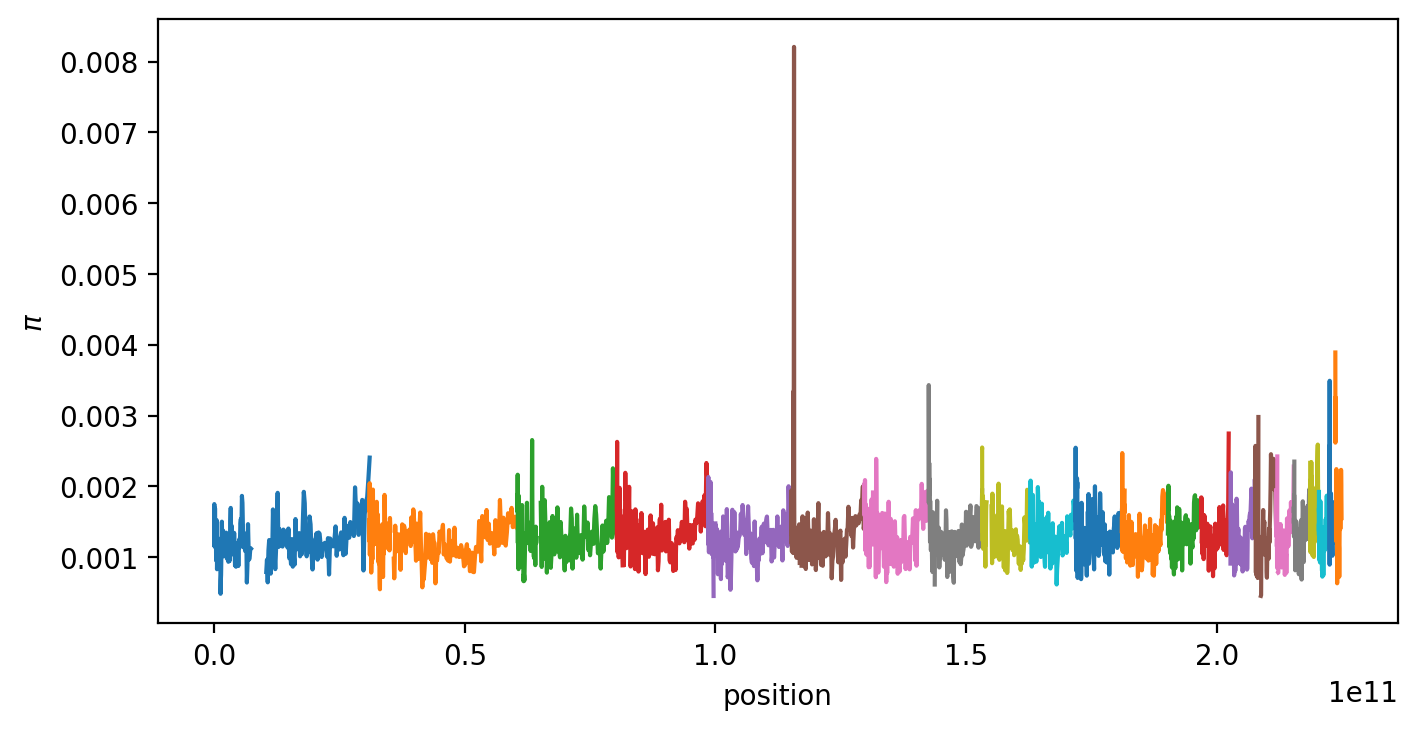

In [190]:
chromplot(bins.flat_midpoints, Y)

Note that there are some extreme outliers. How do these distort the genome-wide distriubtion of $\pi$?

In [198]:
def Y_hist(Y, nbins=100, normal=True):
    """
    Converts Y to π and plots histogram.
    """
    ndiff = Y[:, 1]
    npairs = Y.sum(axis=1)
    pi = np.divide(ndiff, npairs, out=np.full(Y.shape[0], np.nan), 
                   where=npairs > 0)
    _ = plt.hist(pi, nbins, density=True)
    loc, scale = np.nanmean(pi), np.nanstd(pi)    
    if normal:
        z = np.linspace(np.nanmin(pi)*0.99, np.nanmax(pi)*1.01, 1000)
        plt.plot(z, stats.norm(loc=loc, scale=scale).pdf(z), c='r')
    plt.title(f"$\mu={loc:0.4g}, \sigma = {scale:0.4}$")
    plt.xlabel('$\pi$')

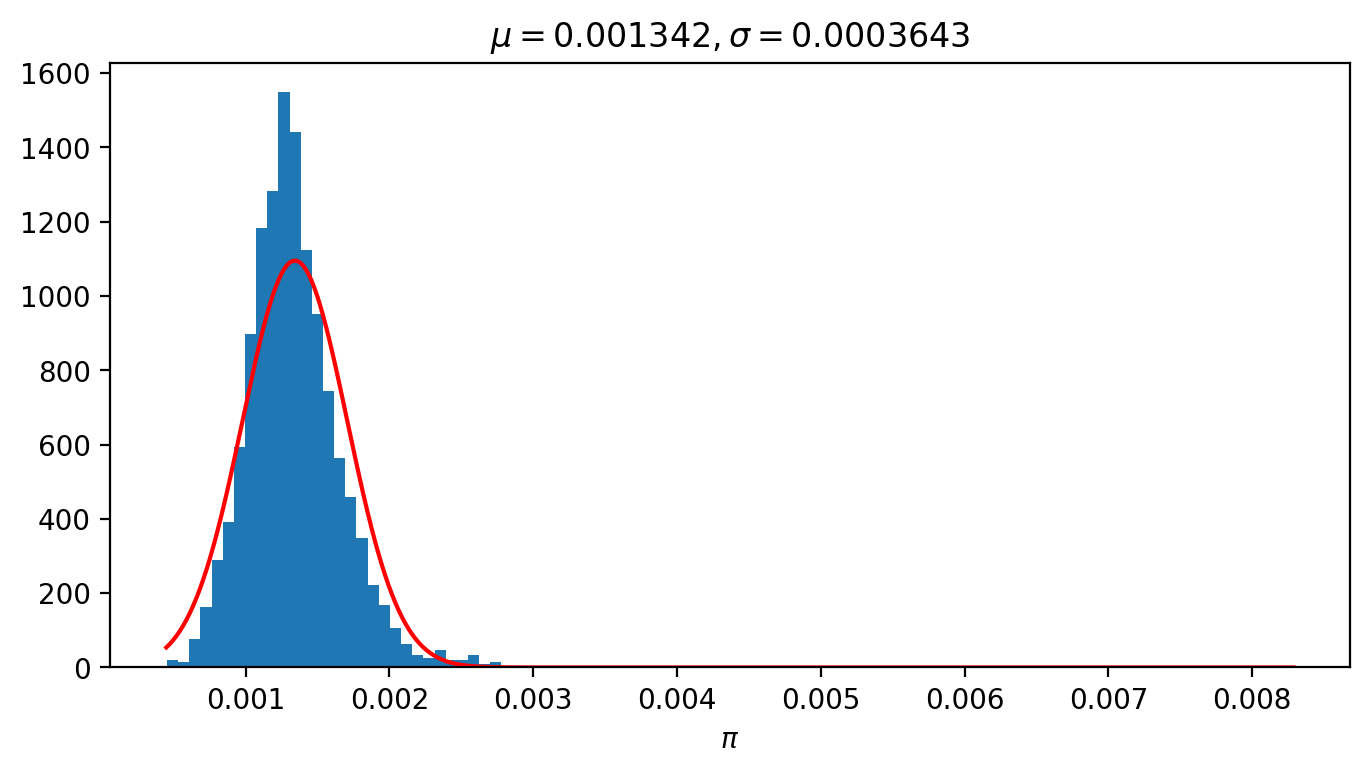

In [199]:
Y_hist(Y)

Let's filter these out by using a trimmed statistic.

In [200]:
def filter_Y(Y, bins, alpha=0.01):
    if isinstance(alpha, float):
        lower, upper = alpha/2, 1-alpha/2
    else:
        lower, upper = alpha
    pi = pi_from_pairwise_summaries(Y)
    idx = (np.nanquantile(pi, lower) < pi) & (np.nanquantile(pi, upper) > pi)
    bins = [b for keep, b in zip(idx, bins.flat) if keep] 
    return bins, Y[idx, :], idx

We'll not trim the left side — only the right.

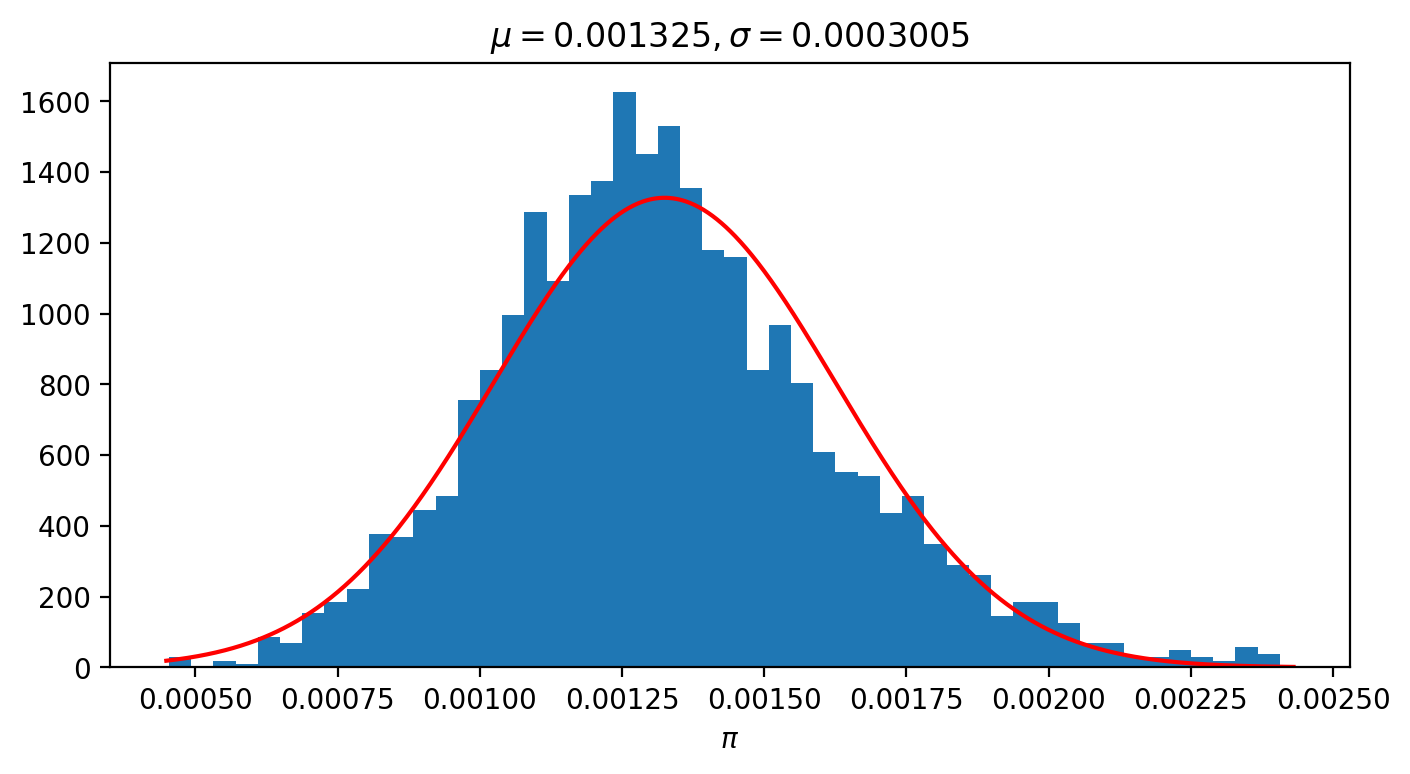

In [201]:
binsf, Yf, idx = filter_Y(Y, bins=bins, alpha=(0.0, 0.99))
Y_hist(Yf, nbins=50)

In [202]:
binsf[:10]

[('chr1', 0, 1000000),
 ('chr1', 1000000, 2000000),
 ('chr1', 2000000, 3000000),
 ('chr1', 3000000, 4000000),
 ('chr1', 4000000, 5000000),
 ('chr1', 5000000, 6000000),
 ('chr1', 6000000, 7000000),
 ('chr1', 7000000, 8000000),
 ('chr1', 8000000, 9000000),
 ('chr1', 9000000, 10000000)]

How close is this to a normal?

In [203]:
pi = pi_from_pairwise_summaries(Yf)
z = np.linspace(pi.min(), pi.max(), 100)
loc, scale = stats.norm.fit(pi)
stats.kstest(pi, stats.norm(loc, scale).cdf)

KstestResult(statistic=0.04371953157613173, pvalue=7.863002370395687e-05)

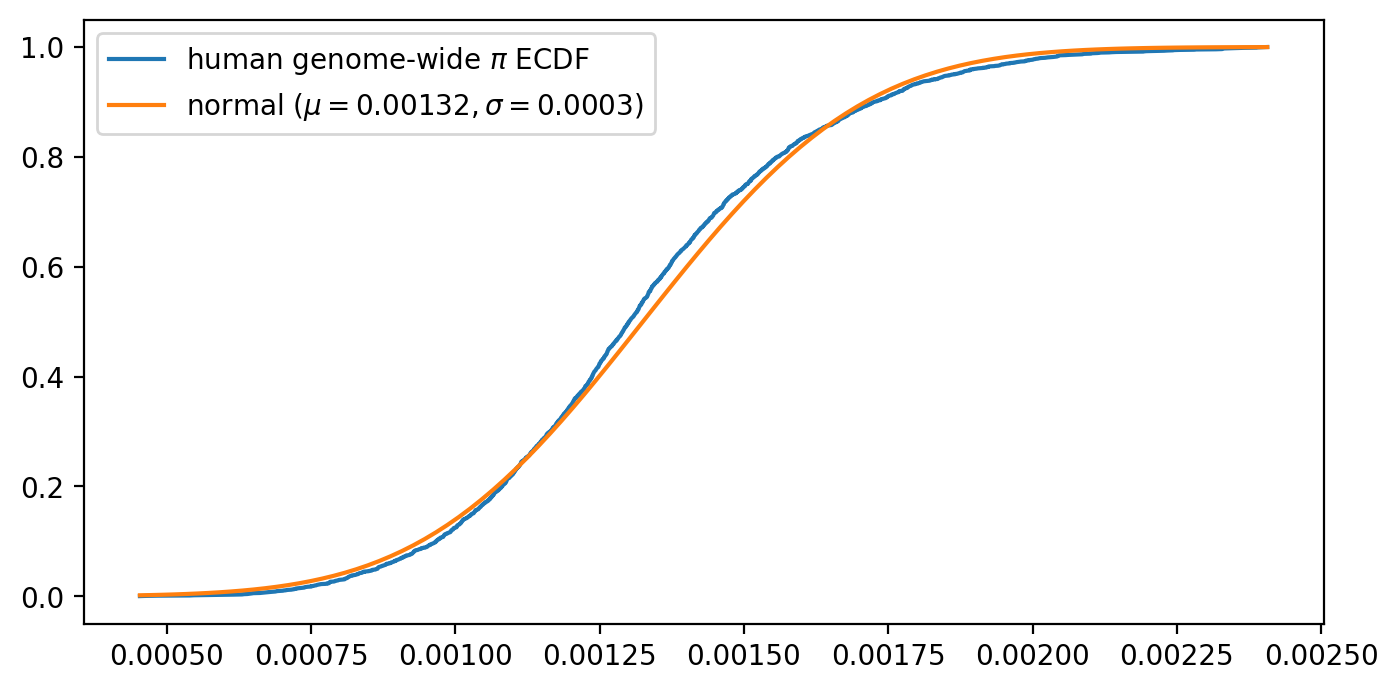

In [204]:
plt.plot(np.sort(pi), (1+np.arange(len(pi)))/len(pi), label='human genome-wide $\pi$ ECDF')
plt.plot(z, stats.norm(*stats.norm.fit(pi)).cdf(z), label=f'normal ($\mu={loc:.3g}, \sigma={scale:.3g}$)')
plt.legend()

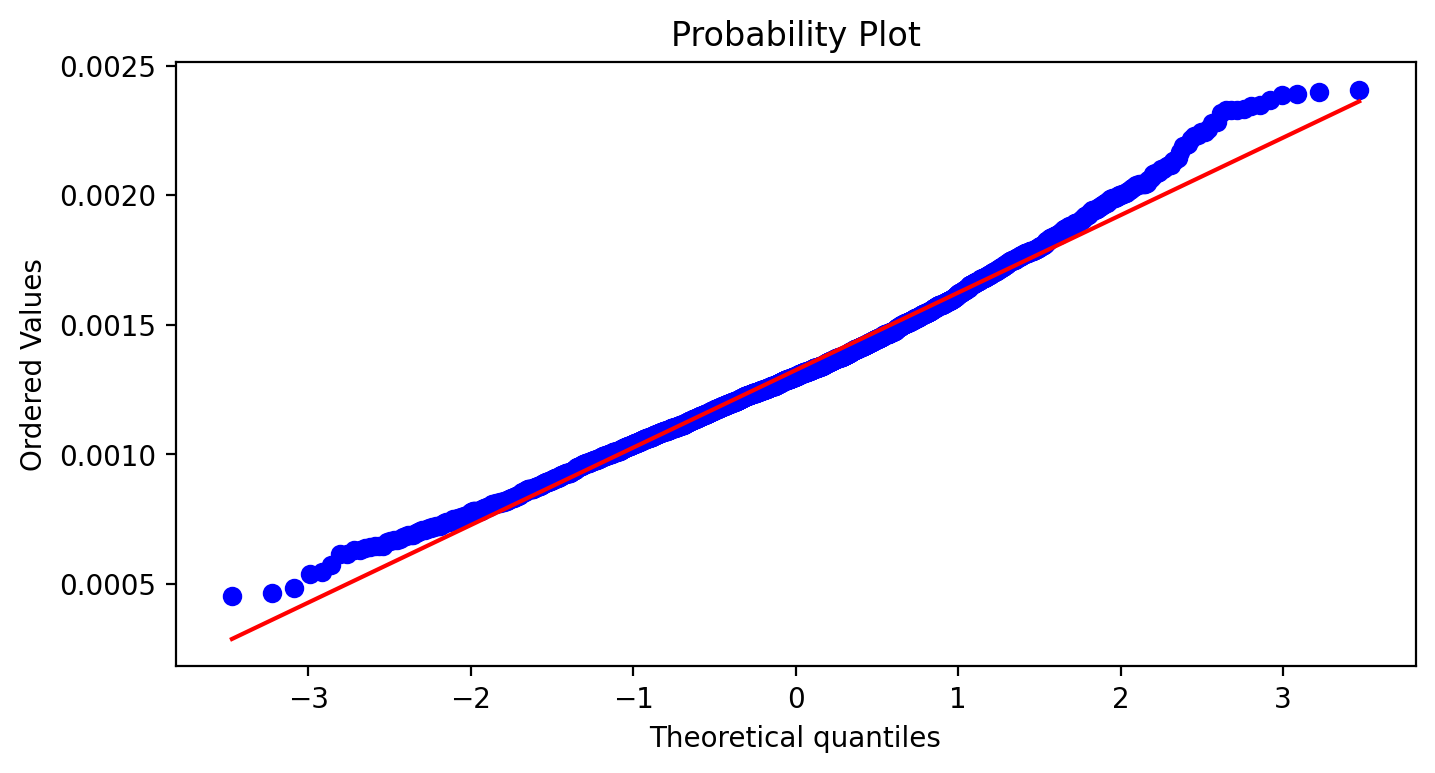

In [205]:
_ = stats.probplot(pi, dist="norm", plot=plt)

Things look a tad distorted. The left tail is a bit thin and the right tail is a bit fat (even after filtering).

In [206]:
# skew and excess kurtosis (Pearson's kurtosis - 3)
stats.skew(pi), stats.kurtosis(pi) - 3

(0.4370890111861593, -2.5854689653735523)

This confirms: excess kurtosis is negative, things are platykurtotic (thin tails). The skew is positive.

Let's look now at the post-trimmed distribution across the genome:

In [207]:
binsf_midpoints = [(c, (start+end)/2) for c, start, end in binsf]

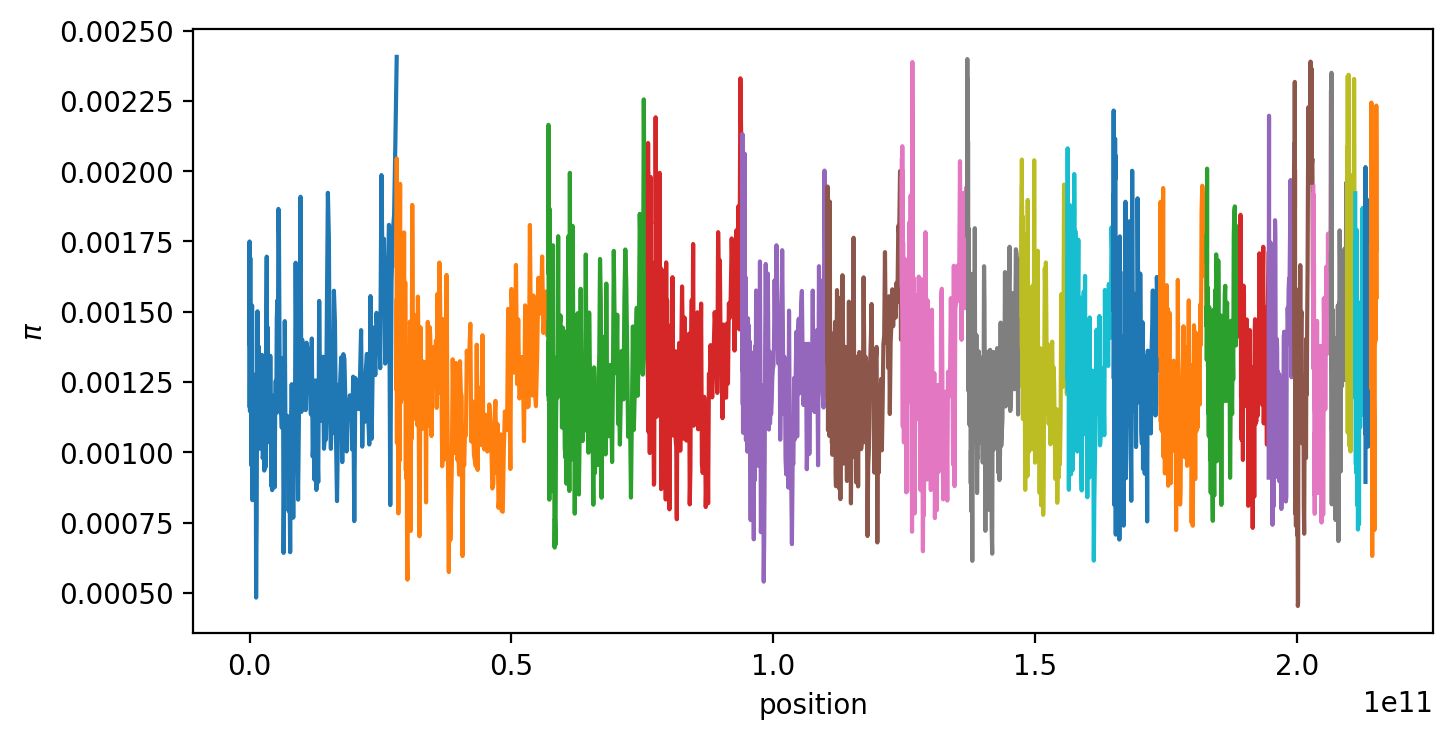

In [208]:
chromplot(binsf_midpoints, Yf)

## Dependencies

Bins are spatially correlated, creating dependencies in the data. We assess and model these here.

Since we reduce data at the megabase bin level, we want to look at the level of autocorrelation/autocovariance at differing levels of bins away using a covariogram. One quick way to do this is

$$g(l) = \mathrm{cov}(i, i+l)$$

where $l$ is the bin index lag. Since recombination rates vary, we also look put this on the natural scale of map position.
 
$$g_m(m) = \mathrm{E}(\mathrm{cov}(i, i+l) | m)$$


In [252]:
# the interface to non-chromosome spanning (e.g. filtered) bins is a bit clunky, hence these:

def midpointbins_to_mapbins(bins):    
    return [(c, float(g.recmap.lookup(c, p, cummulative=True))) for c, p in bins.flat_midpoints]

def bins_to_mapbins(bins):    
    return [(c, float(g.recmap.lookup(c, (s+e)/2, cummulative=True))) for c, s, e in bins]

Whole genome π covariance (note this is an approximation since lags across chromosomes are included).

In [226]:
pi_chroms = np.array([c for c, _, _ in binsf])

Text(0.5, 1.0, 'cov(i, i-1) = 3.308e-08, var(i-1, i-1) = 6.887e-08, var(i, i) = 6.887e-08')

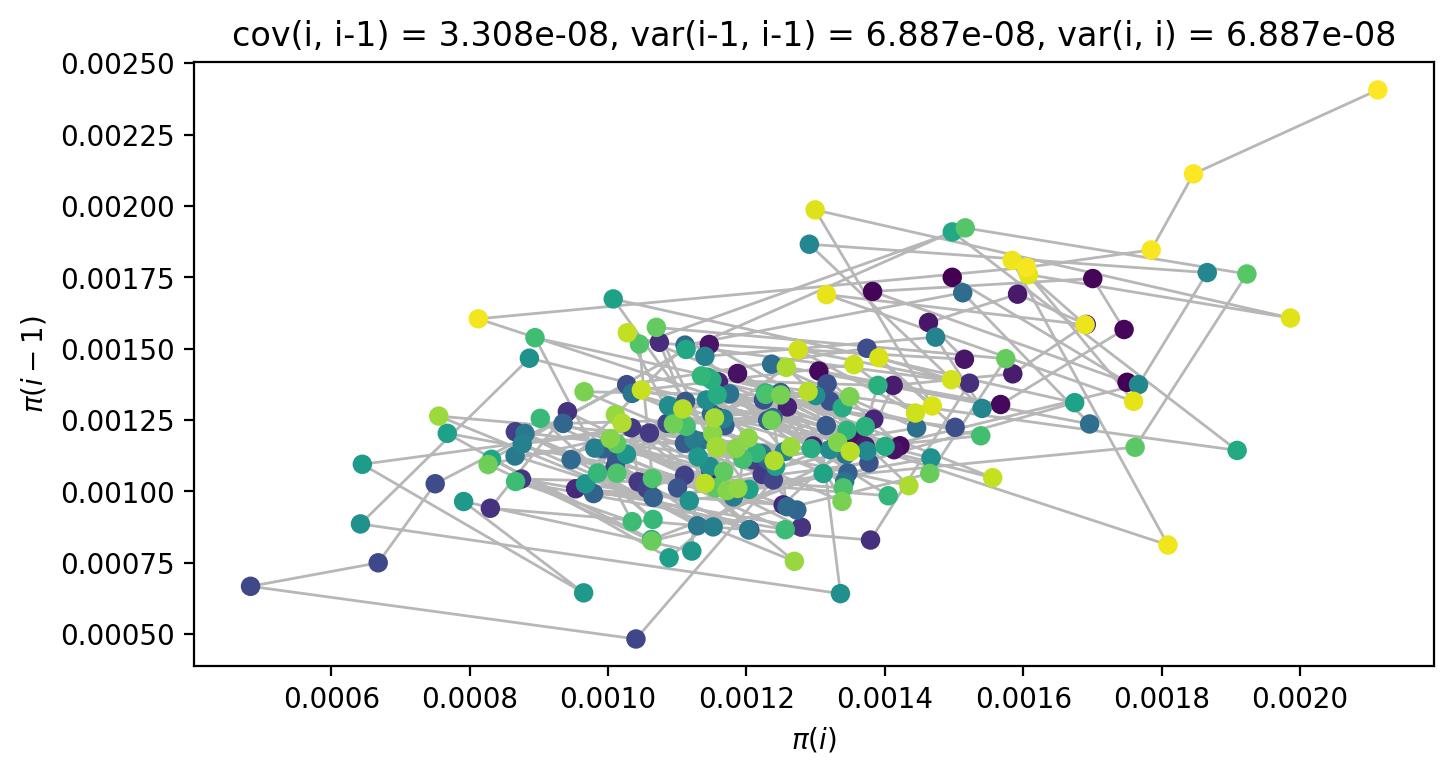

In [227]:
idx2 = pi_chroms == 'chr1'
lag = 1
xpi = pi[idx2]
p1, p2 = xpi[:-(lag)], xpi[(lag):]

plt.plot(p1, p2, linewidth=1, c='0.44', alpha=0.5)
plt.scatter(p1, p2, c=np.arange(len(xpi[(lag):])), zorder=3)
plt.xlabel('$\pi(i)$')
plt.ylabel('$\pi(i-1)$')
#plt.scatter(pi[:-1], pi[1:], c=pi[1:], zorder=3)
cov = np.cov(p1, p2)
plt.title(f"cov(i, i-1) = {cov[0, 1]:.4}, var(i-1, i-1) = {cov[0, 0]:.4}, var(i, i) = {cov[0, 0]:.4}")

Is this first-order covariance significant? Let's do a permutation test:

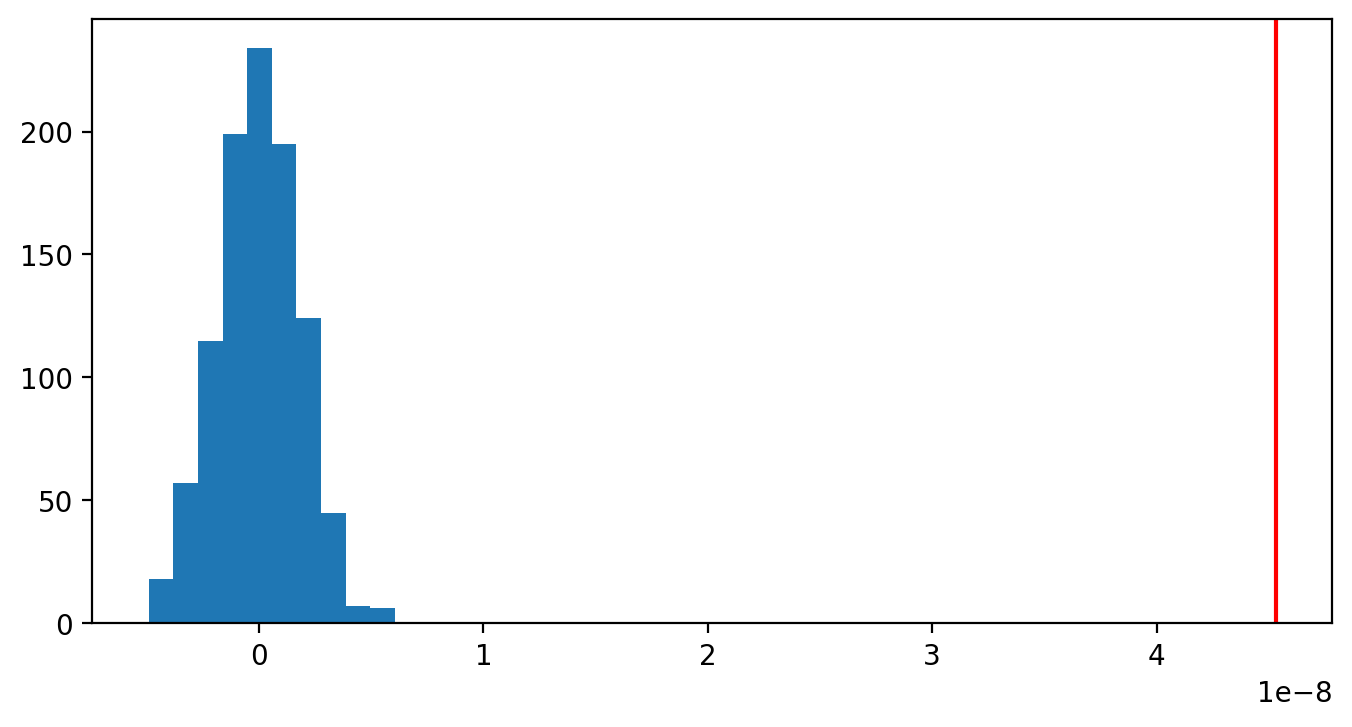

In [230]:
nperms = 1000
null = np.zeros(nperms)
for i in range(nperms):
    null[i] = np.cov(p1, np.random.permutation(p2))[0, 1]

plt.hist(null)
plt.axvline(np.cov(p1, p2)[0, 1], c='r')

In [330]:
def chromosome_variogram(Y, bins, cov=False, min_n = 3):
    lags = list(range(1, 50))
    mlags = []
    covs = []
    ns = []
    xchroms = []
    
    chroms = np.array([c for c, _ in bins])
    mpos = np.array([m for _, m in bins])

    all_chroms = list(set(chroms))
    # things are done at the per-chrom level so that we don't get lag runover
    for chrom in all_chroms:
        idx = chroms == chrom
        y = Y[idx, :]
        x = mpos[idx]
        pi = np.true_divide(y[:, 1], y.sum(axis=1), out=np.full(y.shape[0], np.nan), where=y.sum(axis=1) > 0)
        pi = pi[~np.isnan(pi)]
        chrom_covs = []
        map_lag = []
        for lag in lags:
            p1, p2 = pi[:-lag], pi[lag:]
            if p2.size < min_n or p1.size < min_n:
                chrom_covs.append(np.nan)
                d = np.nan
                map_lag.append(d)
                continue
            d = np.abs(x[:-lag] - x[lag:]).mean()
            if cov:
                chrom_covs.append(np.cov(p1, p2)[0, 1])
            else:
                chrom_covs.append(((p1-p2)**2).mean())
            map_lag.append(d)
        covs.append(chrom_covs)
        mlags.append(map_lag)
    return np.stack(mlags).T, np.stack(covs).T, all_chroms

First, the unfiltered data. Remember, the lag is always a bin shift lag, which is then translated to a map distance (between midpoints).

Text(0.5, 0, 'map distance (Morgans)')

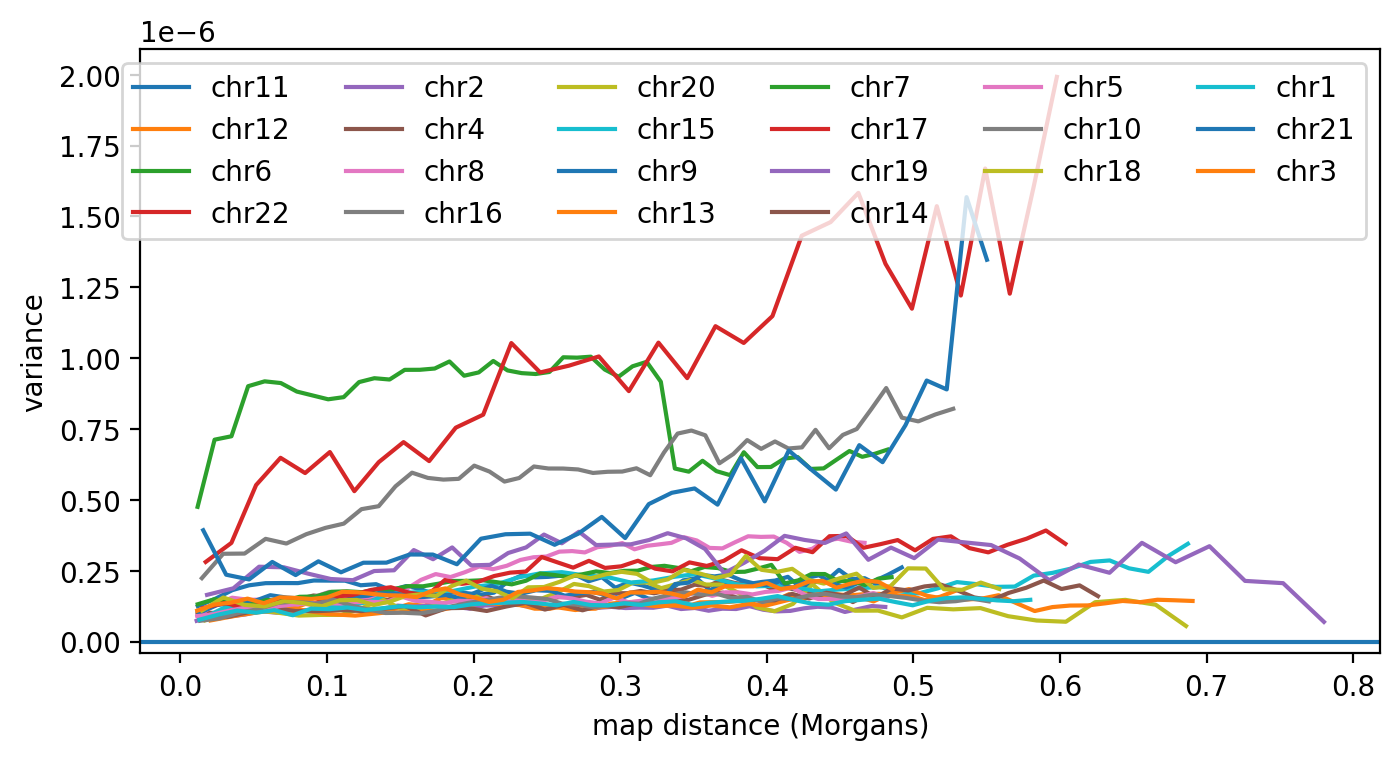

In [331]:
map_bins = midpointbins_to_mapbins(bins)

mlags, covs, covchroms = chromosome_variogram(Y, map_bins)
_ = plt.plot(mlags, covs, label=covchroms)
plt.axhline(0)
plt.legend(ncol=6)
plt.ylabel("variance")
plt.xlabel("map distance (Morgans)")

Text(0.5, 0, 'map distance (Morgans)')

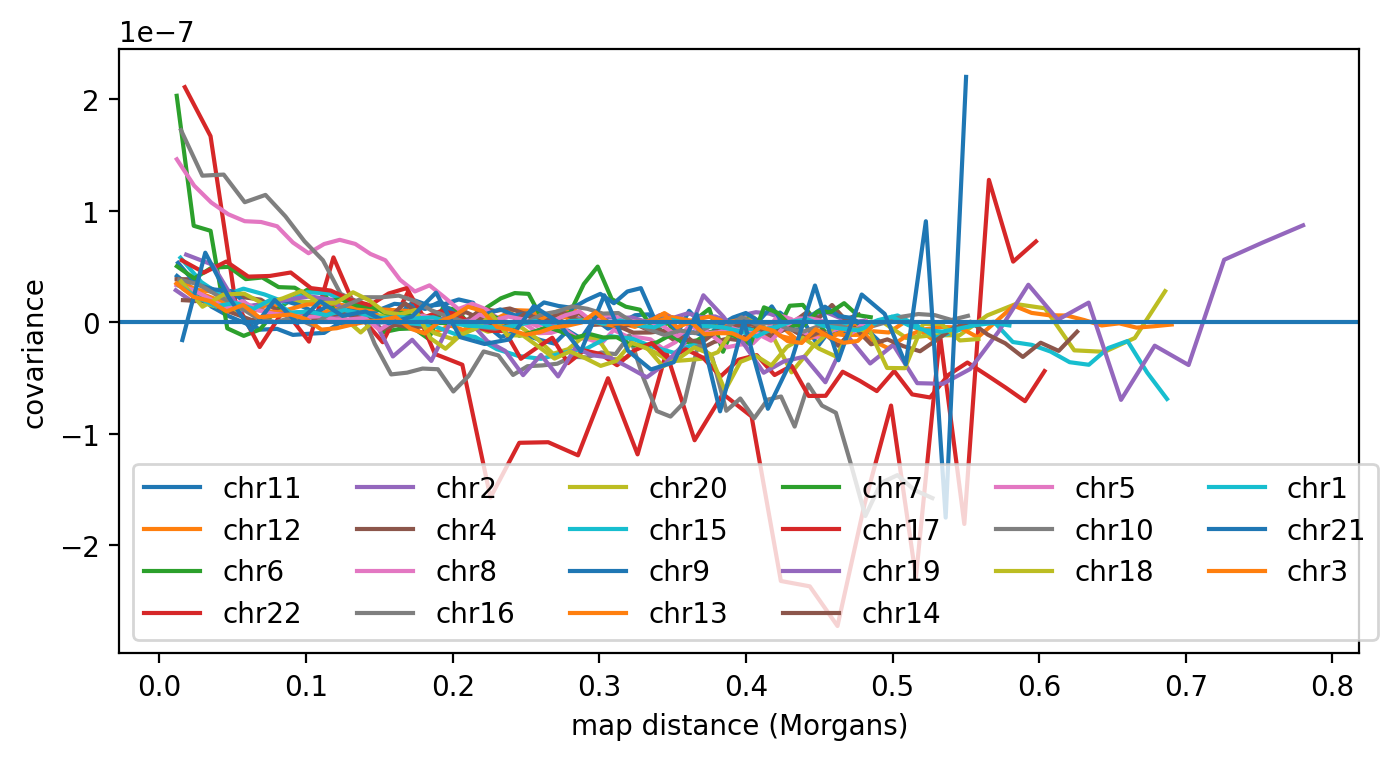

In [332]:
map_bins = midpointbins_to_mapbins(bins)

mlags, covs, covchroms = chromosome_variogram(Y, map_bins, cov=True)
_ = plt.plot(mlags, covs, label=covchroms)
plt.axhline(0)
plt.legend(ncol=6)
plt.ylabel("covariance")
plt.xlabel("map distance (Morgans)")

How does the filtered data look?

Text(0.5, 0, 'map distance (Morgans)')

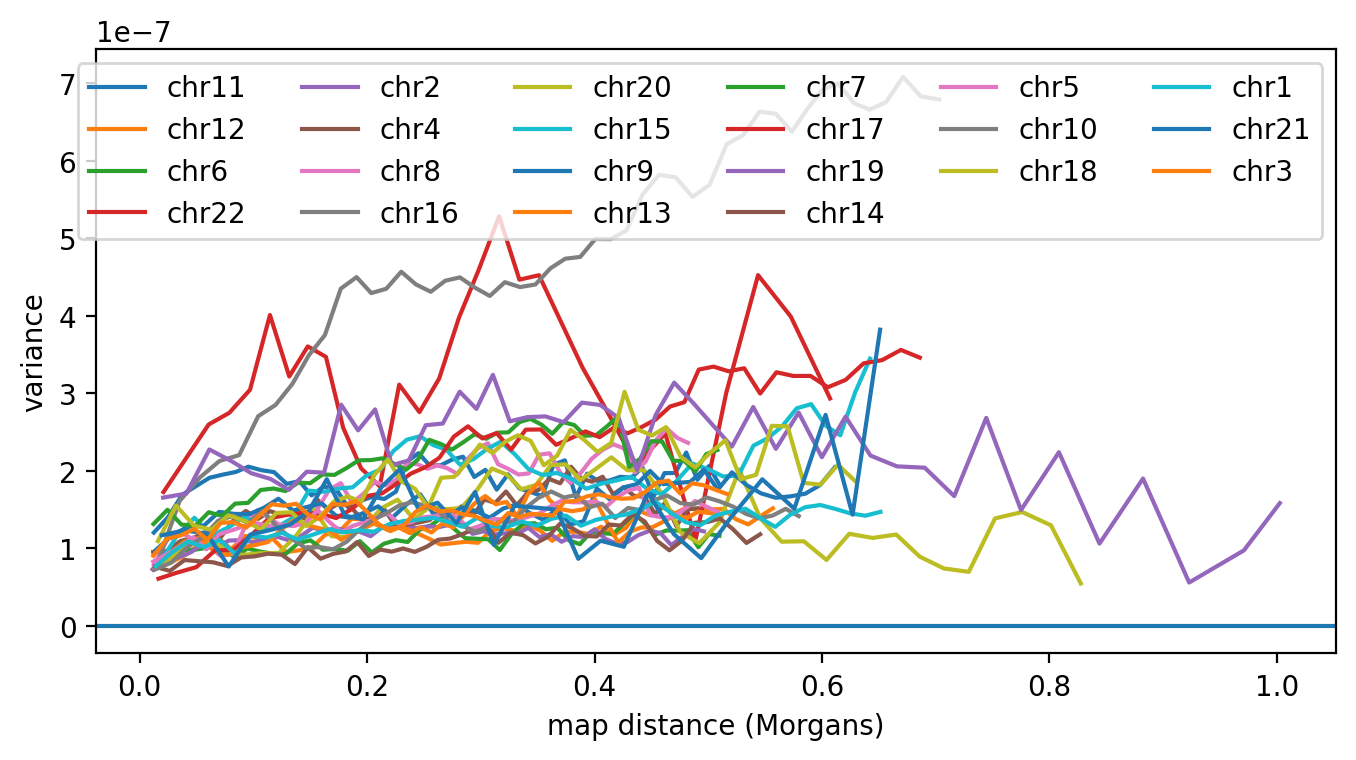

In [333]:
map_binsf = bins_to_mapbins(binsf)

mlags, covs, covchroms = chromosome_variogram(Yf, map_binsf)
_ = plt.plot(mlags, covs, label=covchroms)
plt.axhline(0)
plt.legend(ncol=6)
plt.ylabel("variance")
plt.xlabel("map distance (Morgans)")

Text(0.5, 0, 'map distance (Morgans)')

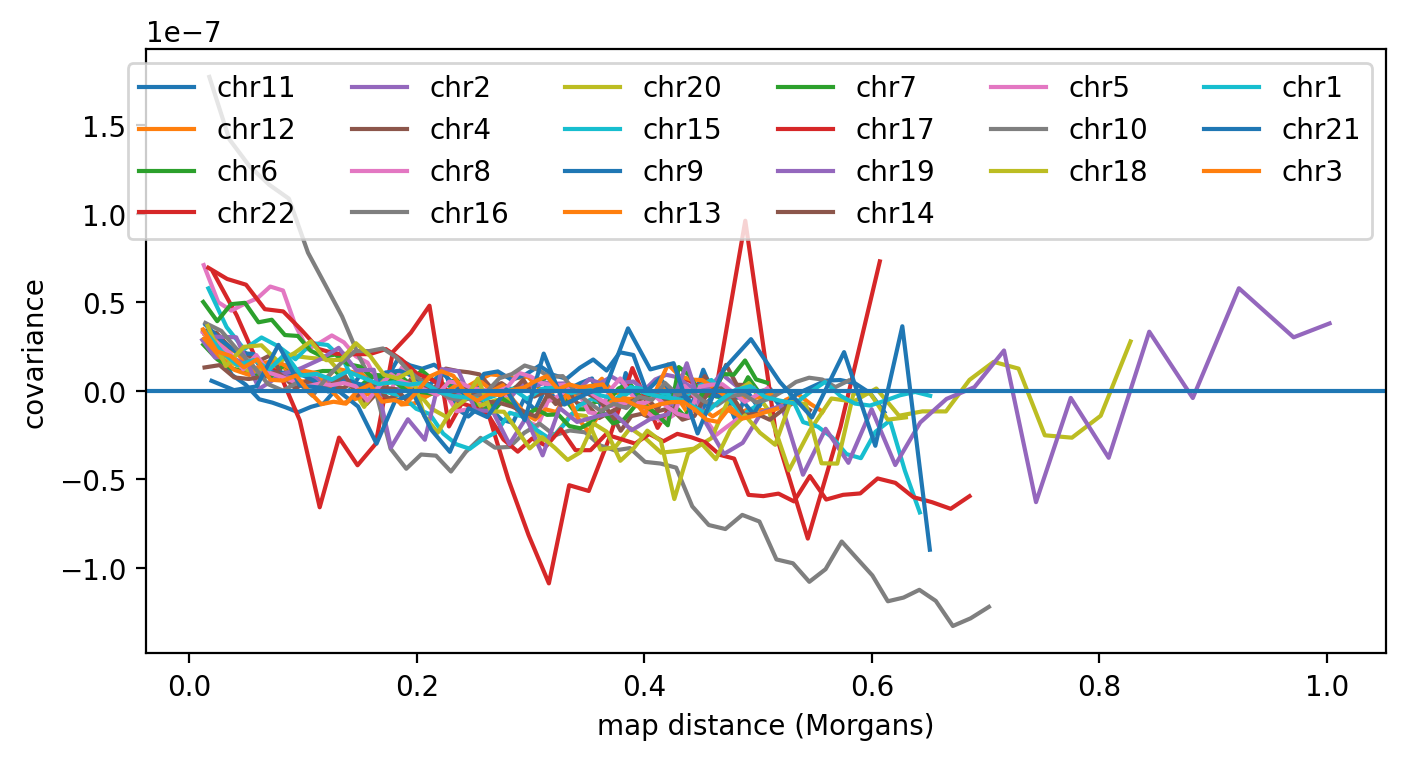

In [334]:
map_binsf = bins_to_mapbins(binsf)

mlags, covs, covchroms = chromosome_variogram(Yf, map_binsf, cov=True)
_ = plt.plot(mlags, covs, label=covchroms)
plt.axhline(0)
plt.legend(ncol=6)
plt.ylabel("covariance")
plt.xlabel("map distance (Morgans)")

Now let's bootstrap the diversity covariogram at the chromosome level:

Text(0, 0.5, 'covariance')

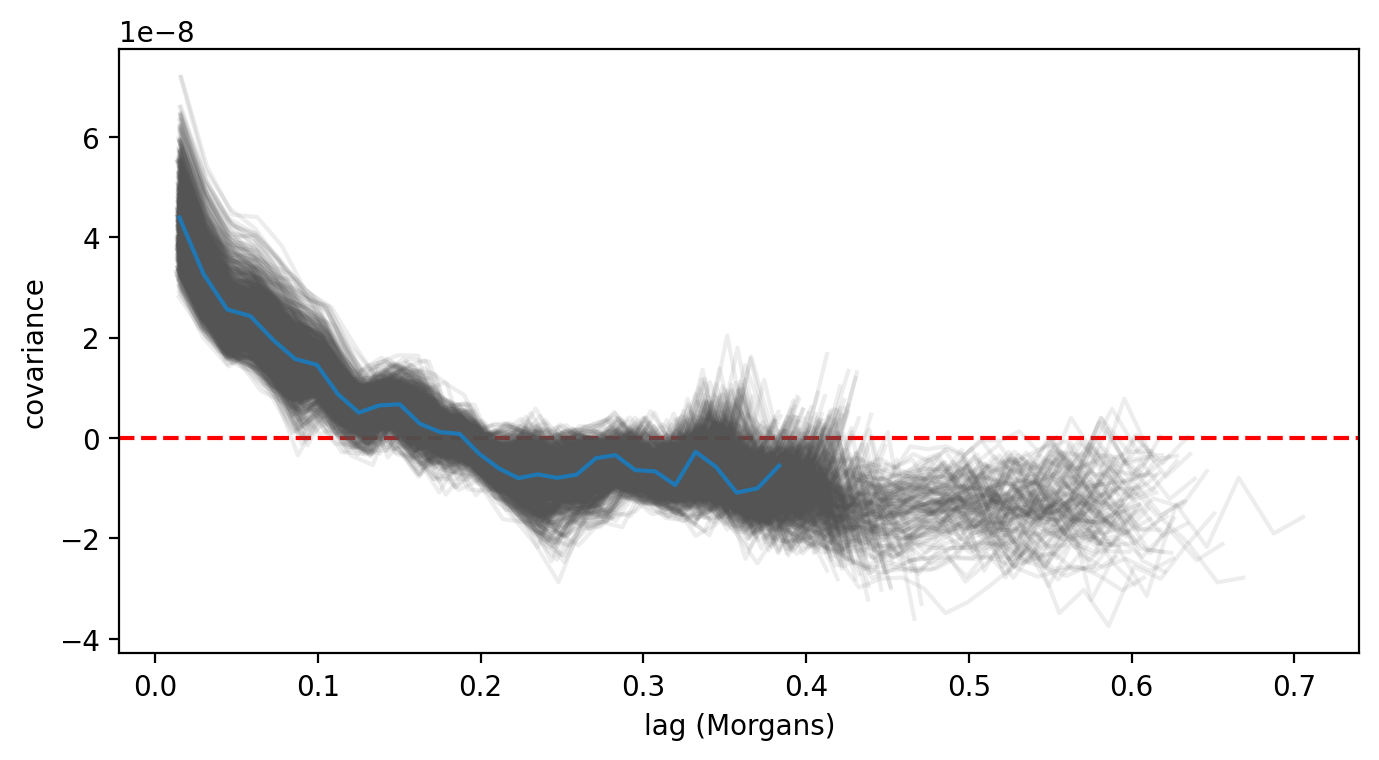

In [335]:
M = covs.T
P = mlags.T
bs = []
ms = []
stat = np.mean
for i in range(1000):
    idx = np.random.randint(0, M.shape[0], M.shape[0])
    bs.append(stat(M[idx, :], axis=0))
    ms.append(stat(P[idx, :], axis=0))
    
_ = plt.plot(np.stack(ms).T, np.stack(bs).T, c='0.33', alpha=0.1)
plt.axhline(0, linestyle='dashed', c='r', zorder=-10)
plt.plot(stat(P, axis=0), stat(M, axis=0))
plt.xlabel('lag (Morgans)')
plt.ylabel('covariance')

Text(0, 0.5, 'covariance')

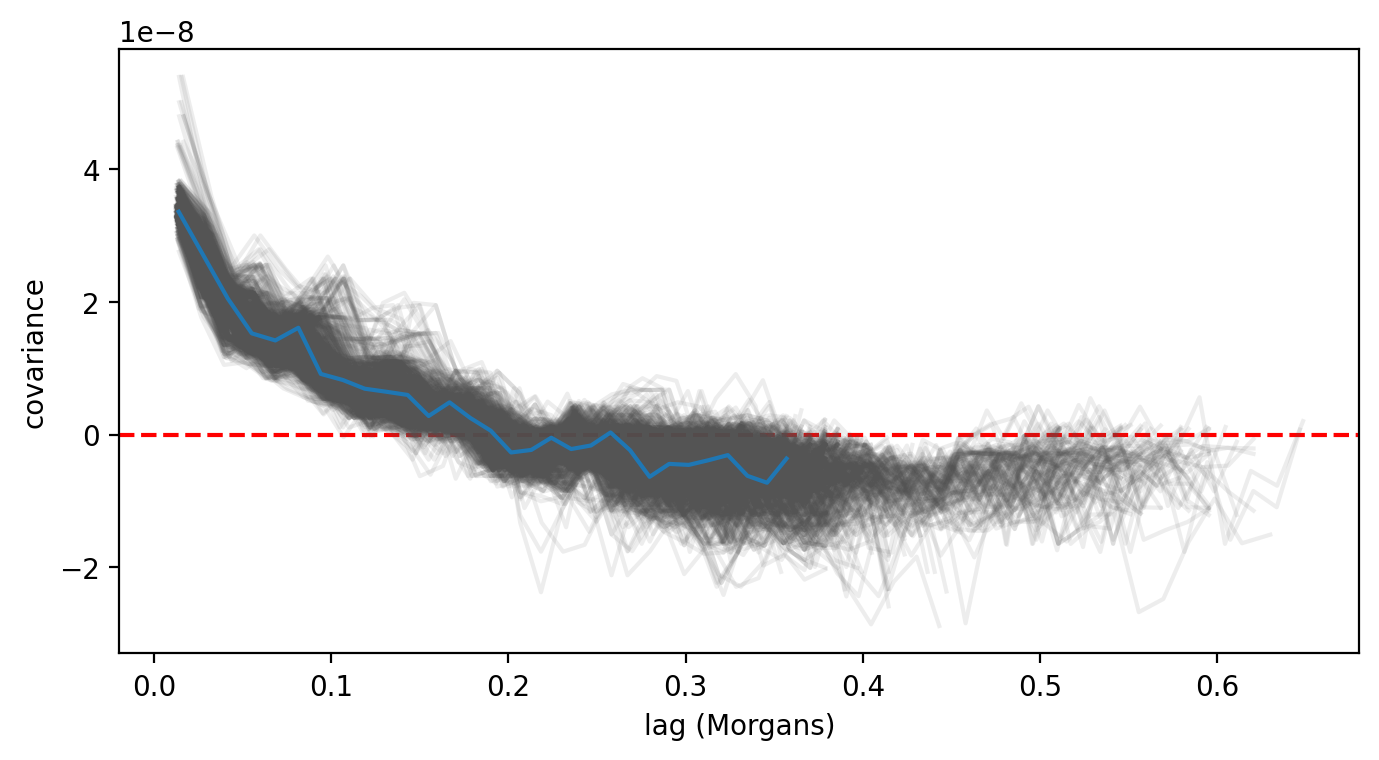

In [336]:
M = covs.T
P = mlags.T
bs = []
ms = []
stat = np.median
for i in range(1000):
    idx = np.random.randint(0, M.shape[0], M.shape[0])
    bs.append(stat(M[idx, :], axis=0))
    ms.append(stat(P[idx, :], axis=0))
    
_ = plt.plot(np.stack(ms).T, np.stack(bs).T, c='0.33', alpha=0.1)
plt.axhline(0, linestyle='dashed', c='r', zorder=-10)
plt.plot(stat(P, axis=0), stat(M, axis=0))
plt.xlabel('lag (Morgans)')
plt.ylabel('covariance')

Text(0, 0.5, 'covariance')

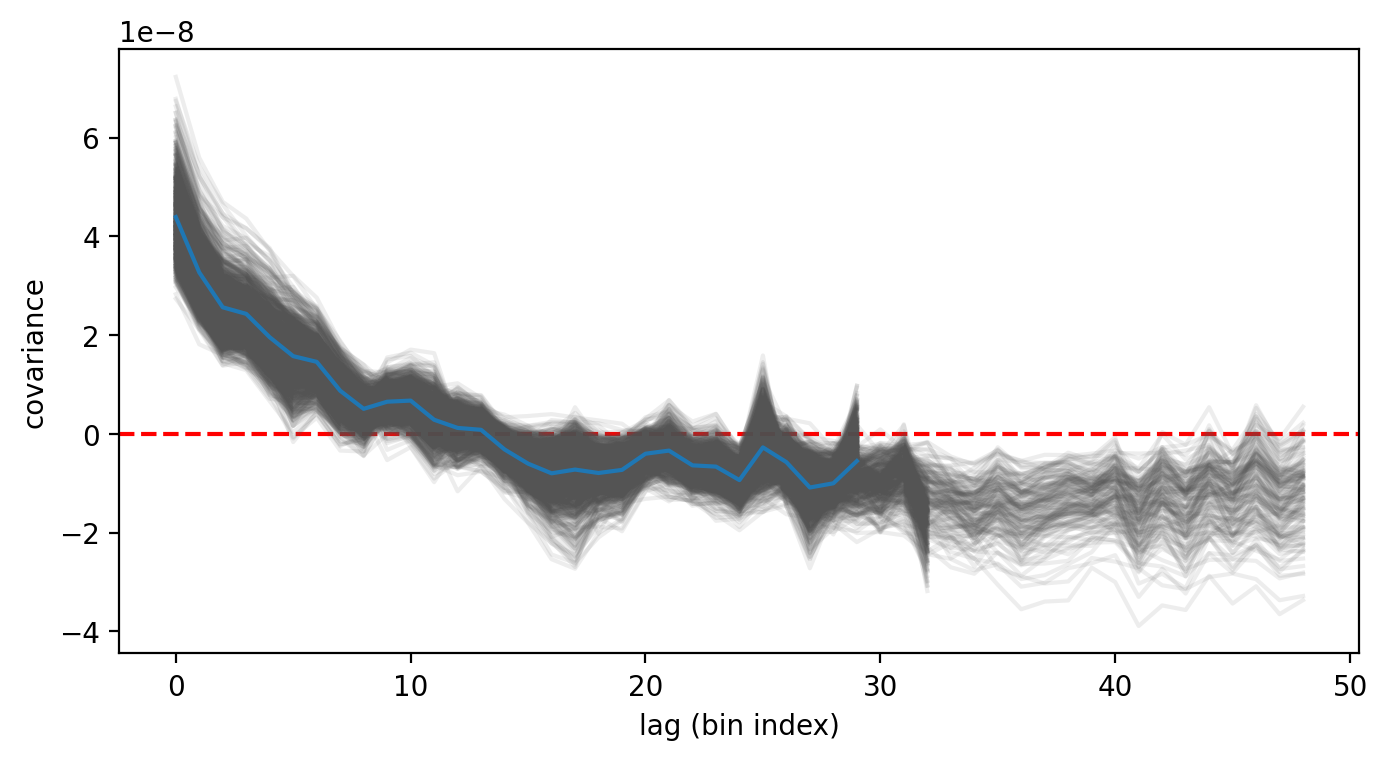

In [309]:
bs = []
for i in range(1000):
    idx = np.random.randint(0, M.shape[0], M.shape[0])
    bs.append(M[idx, :].mean(axis=0))
    
_ = plt.plot(np.stack(bs).T, c='0.33', alpha=0.1)
plt.axhline(0, linestyle='dashed', c='r', zorder=-10)
plt.plot(M.mean(axis=0))
plt.xlabel('lag (bin index)')
plt.ylabel('covariance')

## Parametric Fitting of the Kernel

Let us fit a simple decay kernel

In [424]:
@np.vectorize
def squared_exponential(d, alpha, rho, bias=0):
    # one dimensional
    d = np.abs(d)
    return alpha**2 * np.exp(-0.5 * d**2/rho) + bias

@np.vectorize
def exponential(d, alpha, rho, bias=0):
    # one dimensional
    d = np.abs(d)
    return alpha**2 * np.exp(-0.5 * d/rho) + bias

In [486]:
x, y = np.mean(P, axis=0), np.mean(M, axis=0)
x, y = x[~np.isnan(x)], y[~np.isnan(y)]

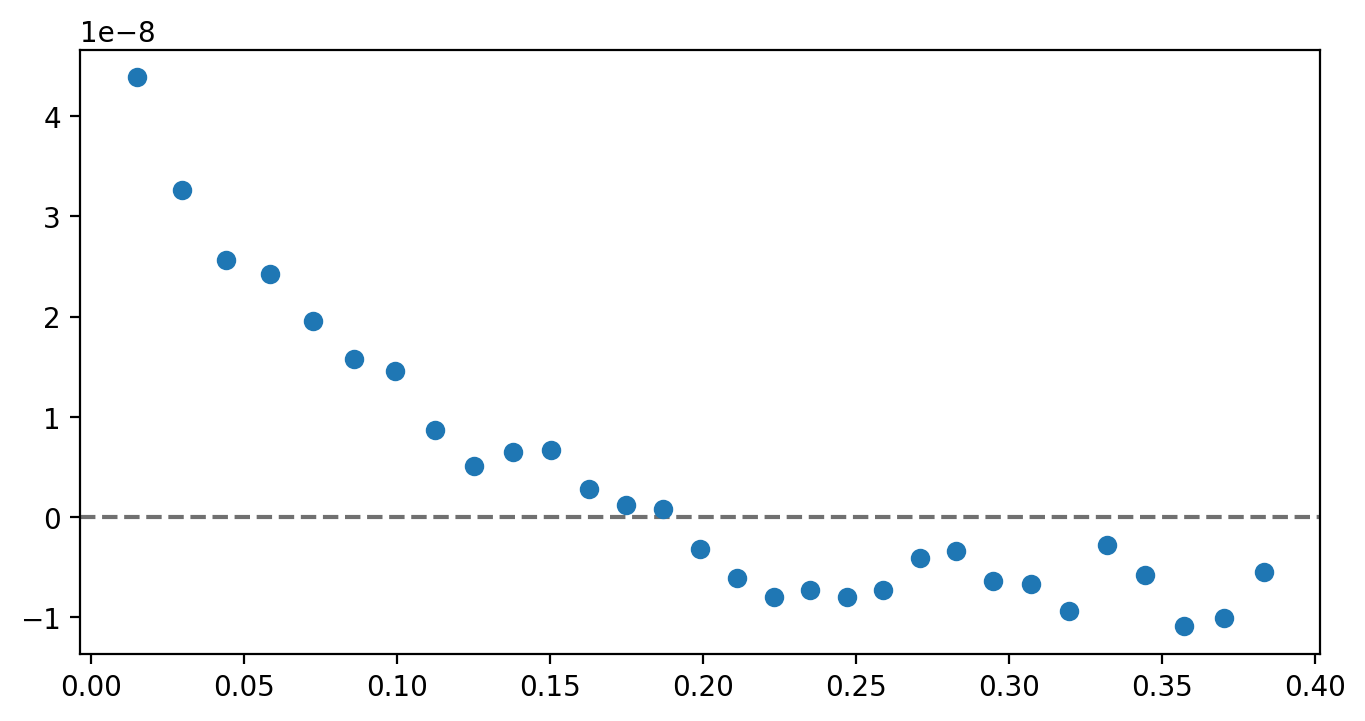

In [693]:
plt.scatter(x, y)
plt.axhline(0, linestyle='dashed', c='0.44', zorder=-10)

In [681]:
from scipy.optimize import minimize, curve_fit

In [682]:
def mse_kernel(x, y):
    def func(theta):
        alpha, rho, bias = theta
        #alpha, rho = 10*alpha, 10**rho
        yp = exponential(x, alpha, rho, bias)
        return np.mean((yp - y)**2) / np.var(y)
    return func
    
opt = minimize(mse_kernel(x, y), 
               x0=[0.0002, 0.04, -1e-9], 
               bounds=[(0, np.Inf), (0, np.Inf), (-np.Inf, np.Inf)], 
               #options={'ftol':1e-3, 'eps':1e-5},
               method='Nelder-Mead')
opt

 final_simplex: (array([[ 2.45358417e-04,  4.84090753e-02, -9.57692055e-09],
       [ 2.45404178e-04,  4.83992206e-02, -9.57810564e-09],
       [ 2.45302290e-04,  4.85061849e-02, -9.60275403e-09],
       [ 2.45347717e-04,  4.84798082e-02, -9.59076119e-09]]), array([0.02922104, 0.02922107, 0.02922109, 0.02922133]))
           fun: 0.02922104024809822
       message: 'Optimization terminated successfully.'
          nfev: 120
           nit: 69
        status: 0
       success: True
             x: array([ 2.45358417e-04,  4.84090753e-02, -9.57692055e-09])

Compare to scipy's `curve_fit()`:

In [683]:
params, param_covs = curve_fit(exponential, x, y, p0=[0.0002, 0.03, -1e-8])
params

array([ 2.45373154e-04,  4.84484112e-02, -9.59431252e-09])

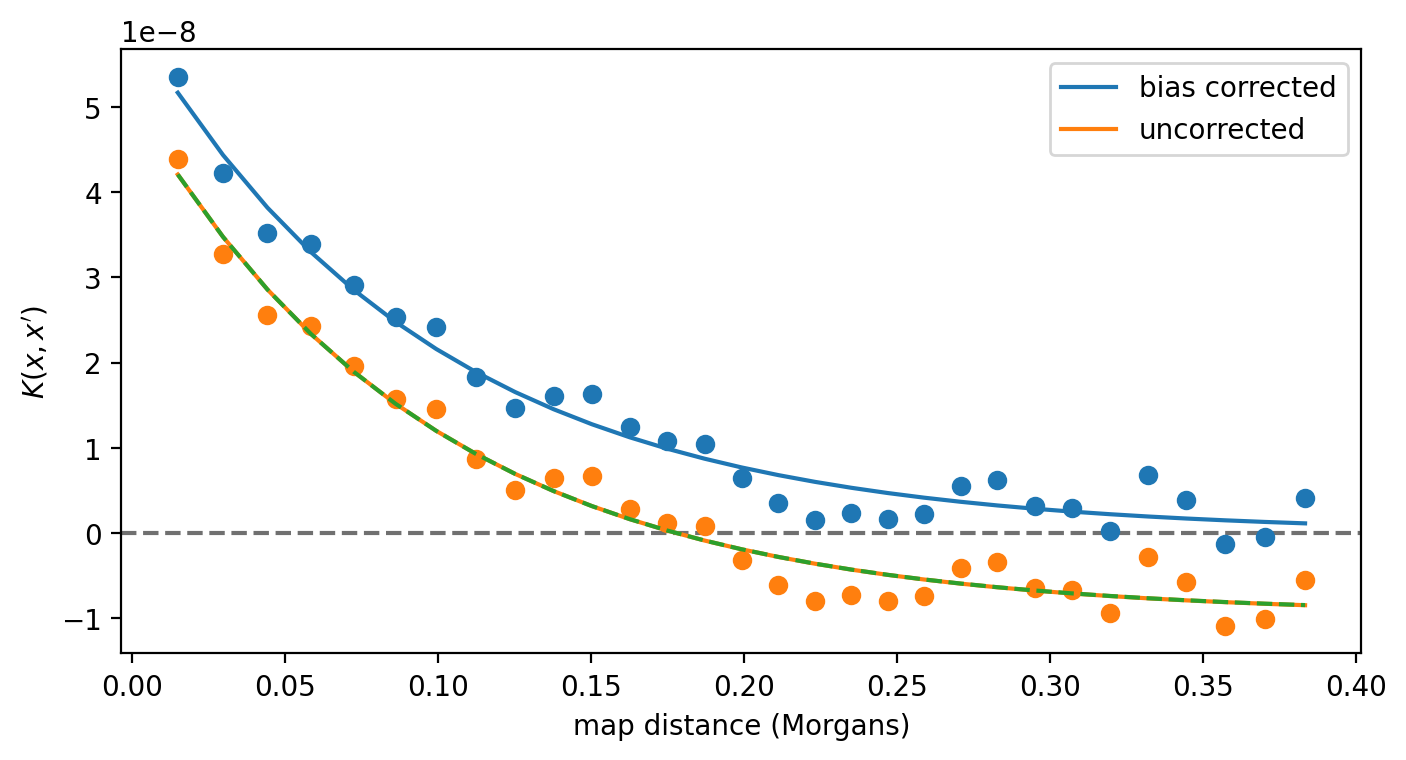

In [712]:
lines = plt.plot(x, exponential(x, *params) - params[2], label='bias corrected')
plt.scatter(x, y - params[2], c=lines[0].get_color())
lines = plt.plot(x, exponential(x, *params), label='uncorrected')
plt.scatter(x, y, c=lines[0].get_color())
plt.plot(x, exponential(x, *opt.x), linestyle='dashed')
plt.axhline(0, linestyle='dashed', c='0.44', zorder=-10)
plt.ylabel("$K(x, x')$")
plt.xlabel('map distance (Morgans)')
plt.legend()

Text(0.5, 0, 'map distance (Morgans)')

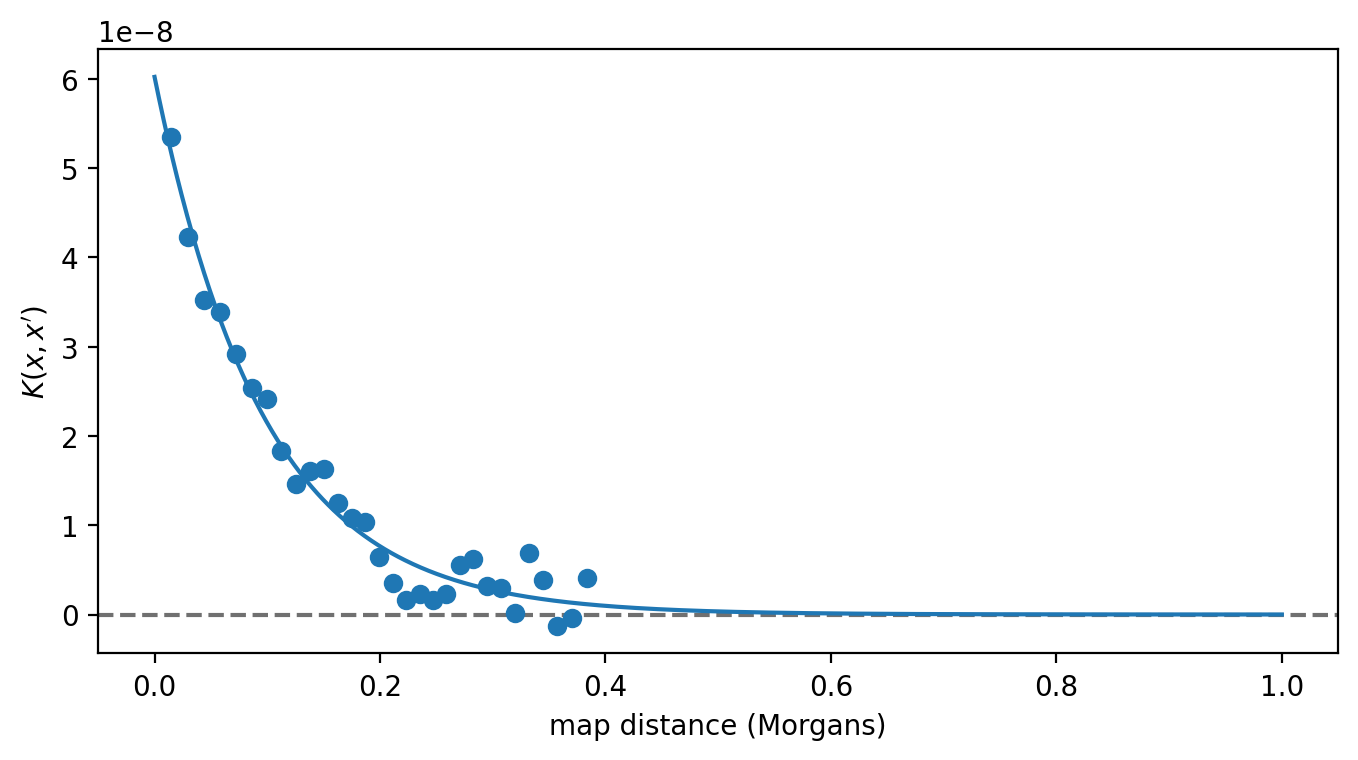

In [713]:
z = np.linspace(0, 1, 1000)
lines = plt.plot(z, exponential(z, *params) - params[2])
plt.scatter(x, y - params[2], c=lines[0].get_color())
plt.axhline(0, linestyle='dashed', c='0.44', zorder=-10)
plt.ylabel("$K(x, x')$")
plt.xlabel('map distance (Morgans)')

In [685]:
def chromosome_covariances(mapbins, kernel):
    chroms = np.array([c for c, _ in mapbins])
    all_chroms = list(set(chroms))
    Sigma = dict()
    for chrom in all_chroms:
        idx = chroms == chrom
        pos = np.array([p for keep, (_, p) in zip(idx.tolist(), mapbins) if keep])
        assert pos.size == idx.sum()
        pos_x, pos_y = np.meshgrid(pos, pos)
        dist = np.abs(pos_x - pos_y)
        Sigma[chrom] = kernel(dist)
    return Sigma

cms = chromosome_covariances(map_binsf, partial(exponential, alpha=params[0], rho=params[1], bias=params[2]))

In [686]:
def is_posdef(X):
    return np.all(np.linalg.eigvals(X) > 0)


offset = np.eye(cms['chr1'].shape[0])*1e-3
is_posdef(cms['chr1'] + offset)

True

In [687]:
Sigma.max()

5.061367213638983e-08

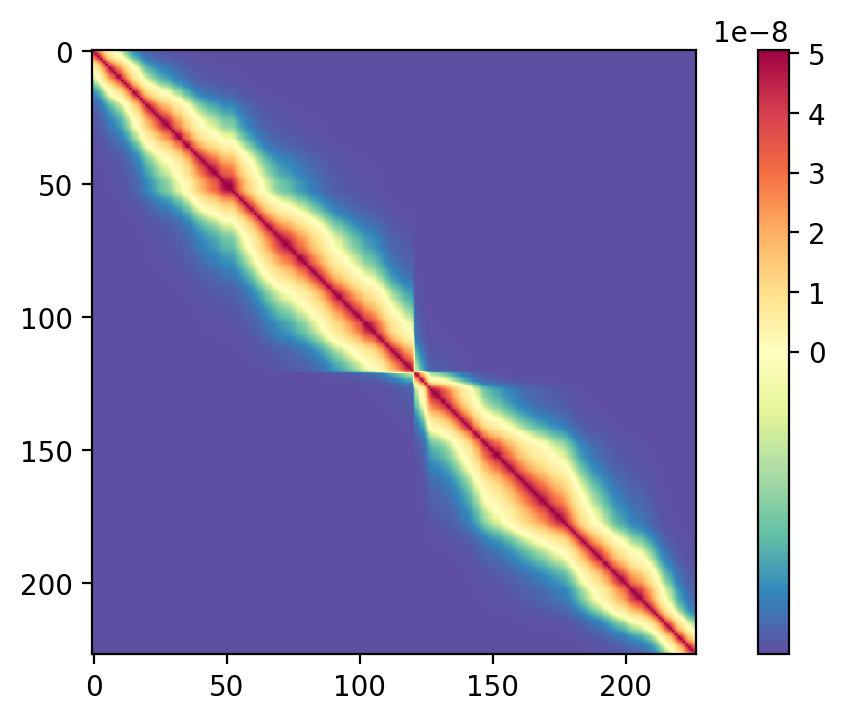

In [688]:
# without fixing bias (note color scale < 0):

Sigma = cms['chr1']

cmap = mpl.cm.get_cmap('Spectral_r')
norm = mpl.colors.TwoSlopeNorm(vmin=Sigma.min(), vcenter=0, vmax=Sigma.max())
cm = plt.imshow(Sigma, cmap=cmap, norm=norm)
plt.colorbar(cm, norm=norm)

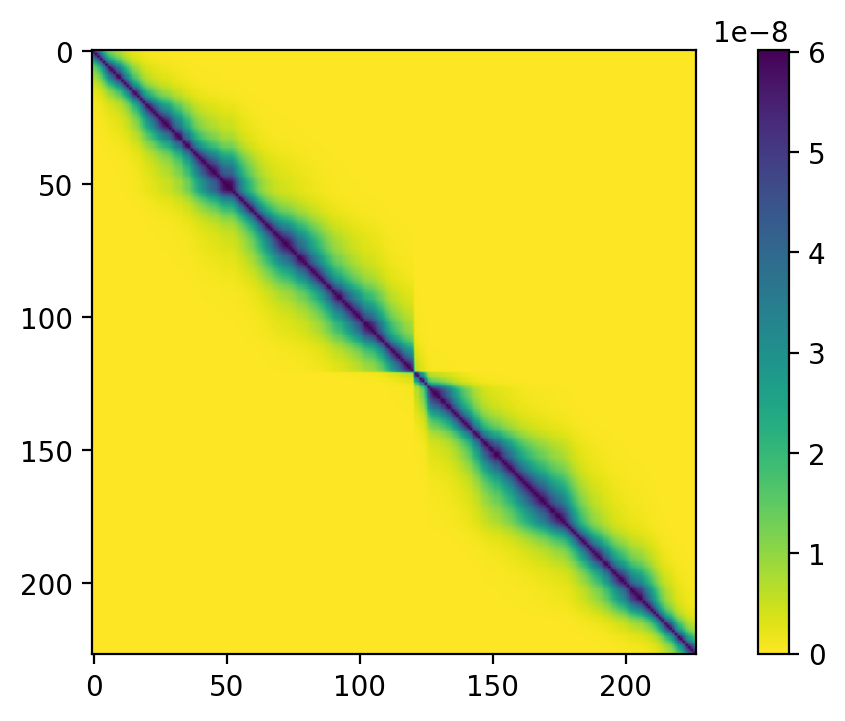

In [716]:
# with fixing bias:

Sigma = cms['chr1']
Sigma_nobias = Sigma - params[2]

cmap = mpl.cm.get_cmap('viridis_r')
norm = mpl.colors.Normalize(vmin=0, vmax=Sigma_nobias.max())
cm = plt.imshow(Sigma_nobias, cmap=cmap, norm=norm)
plt.colorbar(cm, norm=norm)

In [690]:
# how much to offdiagonals contribute to the total? note this ignores the variance, e.g. Σ + σ^2 I 
(Sigma_nobias.sum() - np.diag(Sigma_nobias).sum()) / Sigma_nobias.sum()

0.9346622207866583